In [1]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Global variables
SIZE = 224
CLASSES = 53
BATCH_SIZE = 64

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')

2025-12-05 22:39:16.452697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-05 22:39:16.453392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-05 22:39:16.488469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Cargar datos de test

In [3]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

test_dataset = test_generator.flow_from_directory(
    DATA_PATH + 'test',
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = list(test_dataset.class_indices.keys())
print(f'Numero de clases: {len(class_names)}')
print(f'Total imagenes test: {test_dataset.samples}')

Found 265 images belonging to 53 classes.
Numero de clases: 53
Total imagenes test: 265


## Cargar modelos disponibles

In [4]:
# Importar vit_keras para custom objects (necesario para modelos ViT)
try:
    from vit_keras import vit, layers as vit_layers
    
    # Obtener TODOS los custom objects del modulo vit_keras dinamicamente
    custom_objects = {}
    for name_obj in dir(vit_layers):
        obj = getattr(vit_layers, name_obj)
        if isinstance(obj, type):
            custom_objects[name_obj] = obj
    
    for name_obj in dir(vit):
        obj = getattr(vit, name_obj)
        if isinstance(obj, type):
            custom_objects[name_obj] = obj
    
    print(f"Custom objects ViT registrados: {len(custom_objects)}")
except ImportError:
    print("vit_keras no disponible, solo se cargaran modelos MobileNet y Custom")
    custom_objects = {}

# Lista de modelos a cargar (en orden de preferencia: mejorado primero)
model_candidates = {
    'ViT': ['ViT_B16_3.h5', 'ViT_B16_2.h5'],
    'MobileNet': ['MobileNet_3.h5', 'MobileNet_2.h5'],
    'Custom': ['Custom_4.h5', 'Custom_3.h5']
}

models = {}
model_names = []

for model_type, candidates in model_candidates.items():
    for candidate in candidates:
        model_path = os.path.join(path_models, candidate)
        if os.path.exists(model_path):
            print(f'Cargando {candidate}...')
            try:
                # Cargar con custom_objects si es ViT, sino sin ellos
                if model_type == 'ViT' and custom_objects:
                    models[model_type] = tf.keras.models.load_model(
                        model_path, 
                        custom_objects=custom_objects,
                        compile=False
                    )
                    models[model_type].compile(
                        optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy']
                    )
                else:
                    models[model_type] = tf.keras.models.load_model(model_path)
                
                model_names.append(candidate.replace('.h5', ''))
                print(f'  ✓ {candidate} cargado exitosamente')
                break
            except Exception as e:
                print(f'  ✗ Error cargando {candidate}: {e}')
    else:
        print(f'ADVERTENCIA: No se encontro ningun modelo para {model_type}')

print(f'\nModelos cargados: {list(models.keys())}')

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Custom objects ViT registrados: 5
Cargando ViT_B16_3.h5...
  ✓ ViT_B16_3.h5 cargado exitosamente
Cargando MobileNet_3.h5...
  ✓ MobileNet_3.h5 cargado exitosamente
Cargando Custom_4.h5...
  ✓ Custom_4.h5 cargado exitosamente

Modelos cargados: ['ViT', 'MobileNet', 'Custom']


## Evaluar modelos individuales

In [5]:
individual_accuracies = {}
individual_predictions = {}

for model_name, model in models.items():
    print(f'\nEvaluando {model_name}...')
    
    # Evaluar
    _, accuracy = model.evaluate(test_dataset, verbose=0)
    individual_accuracies[model_name] = accuracy
    
    # Obtener predicciones (probabilidades)
    test_dataset.reset()
    predictions = model.predict(test_dataset, verbose=0)
    individual_predictions[model_name] = predictions
    
    print(f'{model_name}: Accuracy = {accuracy:.4f}')

# Resetear generador
test_dataset.reset()


Evaluando ViT...
ViT: Accuracy = 0.9698

Evaluando MobileNet...
MobileNet: Accuracy = 0.9283

Evaluando Custom...
Custom: Accuracy = 0.9698


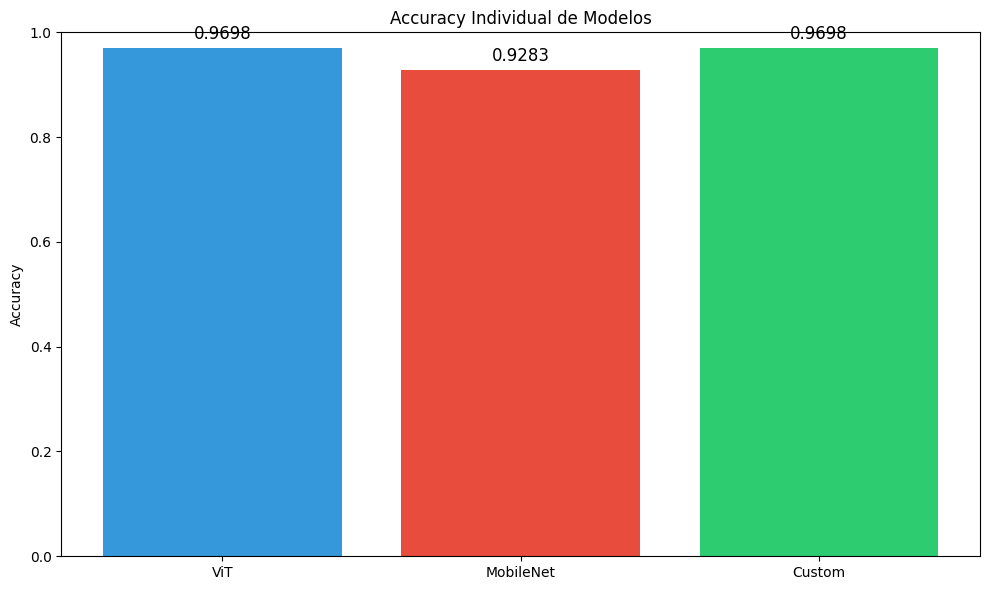

In [21]:
# Visualizar accuracies individuales
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(individual_accuracies.keys(), individual_accuracies.values(), color=['#3498db', '#e74c3c', '#2ecc71'])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Individual de Modelos')
ax.set_ylim(0, 1)

for bar, acc in zip(bars, individual_accuracies.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{acc:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(path_results, 'individual_accuracies.png'), dpi=150)
plt.show()

## Ensemble: Soft Voting (promedio simple)

In [22]:
def soft_voting(predictions_dict):
    """Promedio simple de probabilidades"""
    preds_list = list(predictions_dict.values())
    return np.mean(preds_list, axis=0)

def weighted_voting(predictions_dict, weights_dict):
    """Promedio ponderado de probabilidades"""
    weighted_preds = []
    total_weight = sum(weights_dict.values())
    
    for model_name, preds in predictions_dict.items():
        weight = weights_dict[model_name] / total_weight
        weighted_preds.append(preds * weight)
    
    return np.sum(weighted_preds, axis=0)

def calculate_accuracy(predictions, true_labels):
    """Calcular accuracy a partir de probabilidades"""
    pred_classes = predictions.argmax(axis=1)
    return np.mean(pred_classes == true_labels)

In [24]:
# Obtener true labels
true_labels = test_dataset.labels

# Soft voting (promedio simple)
ensemble_soft = soft_voting(individual_predictions)
acc_soft = calculate_accuracy(ensemble_soft, true_labels)
print(f'Ensemble (Soft Voting): Accuracy = {acc_soft:.4f}')

Ensemble (Soft Voting): Accuracy = 0.9774


## Ensemble: Weighted Voting (ponderado por accuracy)

In [25]:
# Usar accuracy como pesos
ensemble_weighted = weighted_voting(individual_predictions, individual_accuracies)
acc_weighted = calculate_accuracy(ensemble_weighted, true_labels)
print(f'Ensemble (Weighted Voting): Accuracy = {acc_weighted:.4f}')

Ensemble (Weighted Voting): Accuracy = 0.9774


In [26]:
# Optimizar pesos manualmente
# Dar mas peso al mejor modelo
best_model = max(individual_accuracies, key=individual_accuracies.get)
optimized_weights = {name: 1.0 for name in models.keys()}
optimized_weights[best_model] = 2.0  # Doble peso al mejor

print(f'Pesos optimizados: {optimized_weights}')

ensemble_optimized = weighted_voting(individual_predictions, optimized_weights)
acc_optimized = calculate_accuracy(ensemble_optimized, true_labels)
print(f'Ensemble (Optimized Voting): Accuracy = {acc_optimized:.4f}')

Pesos optimizados: {'ViT': 2.0, 'MobileNet': 1.0, 'Custom': 1.0}
Ensemble (Optimized Voting): Accuracy = 0.9736


## Comparacion de resultados

In [27]:
# Resumen de todos los resultados
results = {
    **{f'{name} (Individual)': acc for name, acc in individual_accuracies.items()},
    'Ensemble (Soft Voting)': acc_soft,
    'Ensemble (Weighted)': acc_weighted,
    'Ensemble (Optimized)': acc_optimized
}

results_df = pd.DataFrame({
    'Modelo': results.keys(),
    'Accuracy': results.values()
}).sort_values('Accuracy', ascending=False)

print('\n=== RANKING DE MODELOS ===')
print(results_df.to_string(index=False))


=== RANKING DE MODELOS ===
                Modelo  Accuracy
Ensemble (Soft Voting)  0.977358
   Ensemble (Weighted)  0.977358
  Ensemble (Optimized)  0.973585
      ViT (Individual)  0.969811
   Custom (Individual)  0.969811
MobileNet (Individual)  0.928302


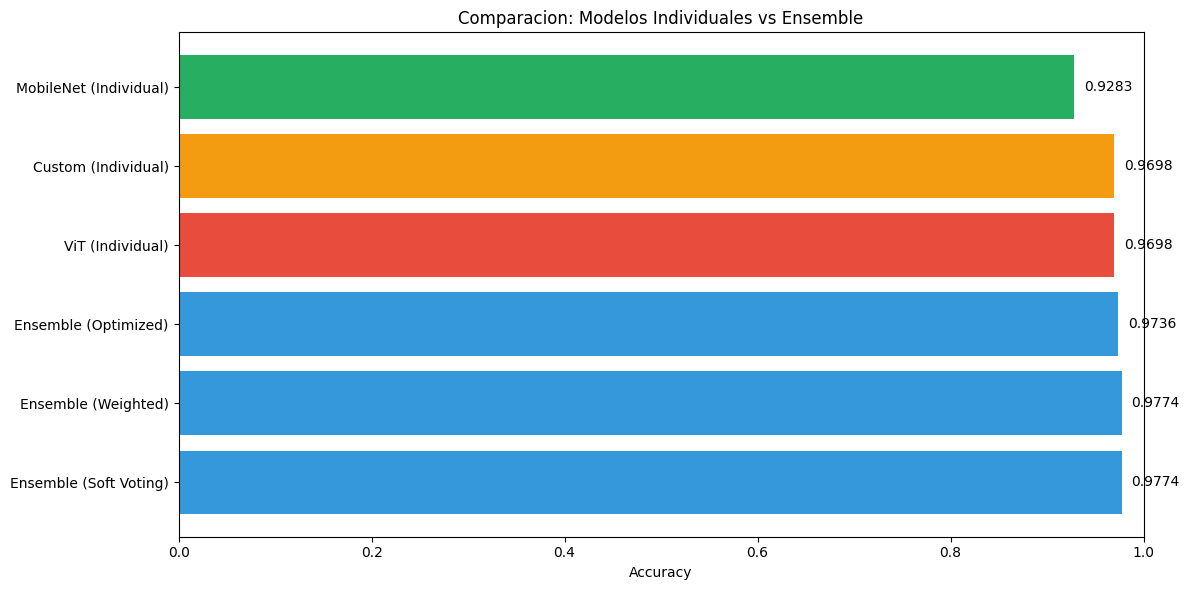

In [28]:
# Visualizar comparacion
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#3498db'] * len(individual_accuracies) + ['#e74c3c', '#f39c12', '#27ae60']
bars = ax.barh(results_df['Modelo'], results_df['Accuracy'], color=colors)

ax.set_xlabel('Accuracy')
ax.set_title('Comparacion: Modelos Individuales vs Ensemble')
ax.set_xlim(0, 1)

for bar, acc in zip(bars, results_df['Accuracy']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{acc:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(path_results, 'ensemble_comparison.png'), dpi=150)
plt.show()

## Classification Report del mejor ensemble

In [29]:
# Seleccionar el mejor ensemble
ensemble_results = {
    'soft': acc_soft,
    'weighted': acc_weighted,
    'optimized': acc_optimized
}
best_ensemble_type = max(ensemble_results, key=ensemble_results.get)

if best_ensemble_type == 'soft':
    best_ensemble_preds = ensemble_soft
elif best_ensemble_type == 'weighted':
    best_ensemble_preds = ensemble_weighted
else:
    best_ensemble_preds = ensemble_optimized

print(f'Mejor ensemble: {best_ensemble_type} con accuracy {ensemble_results[best_ensemble_type]:.4f}')

Mejor ensemble: soft con accuracy 0.9774


In [30]:
# Classification report
pred_classes = best_ensemble_preds.argmax(axis=1)
true_text = [class_names[i] for i in true_labels]
pred_text = [class_names[i] for i in pred_classes]

print('\n=== Classification Report (Ensemble) ===')
print(classification_report(true_text, pred_text))


=== Classification Report (Ensemble) ===
                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       1.00      1.00      1.00         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       1.00      1.00      1.00         5
    five of clubs       1.00      0.80      0.89         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       1.00      1.00      1.00         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       1.00      1.00      1.00         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of sp

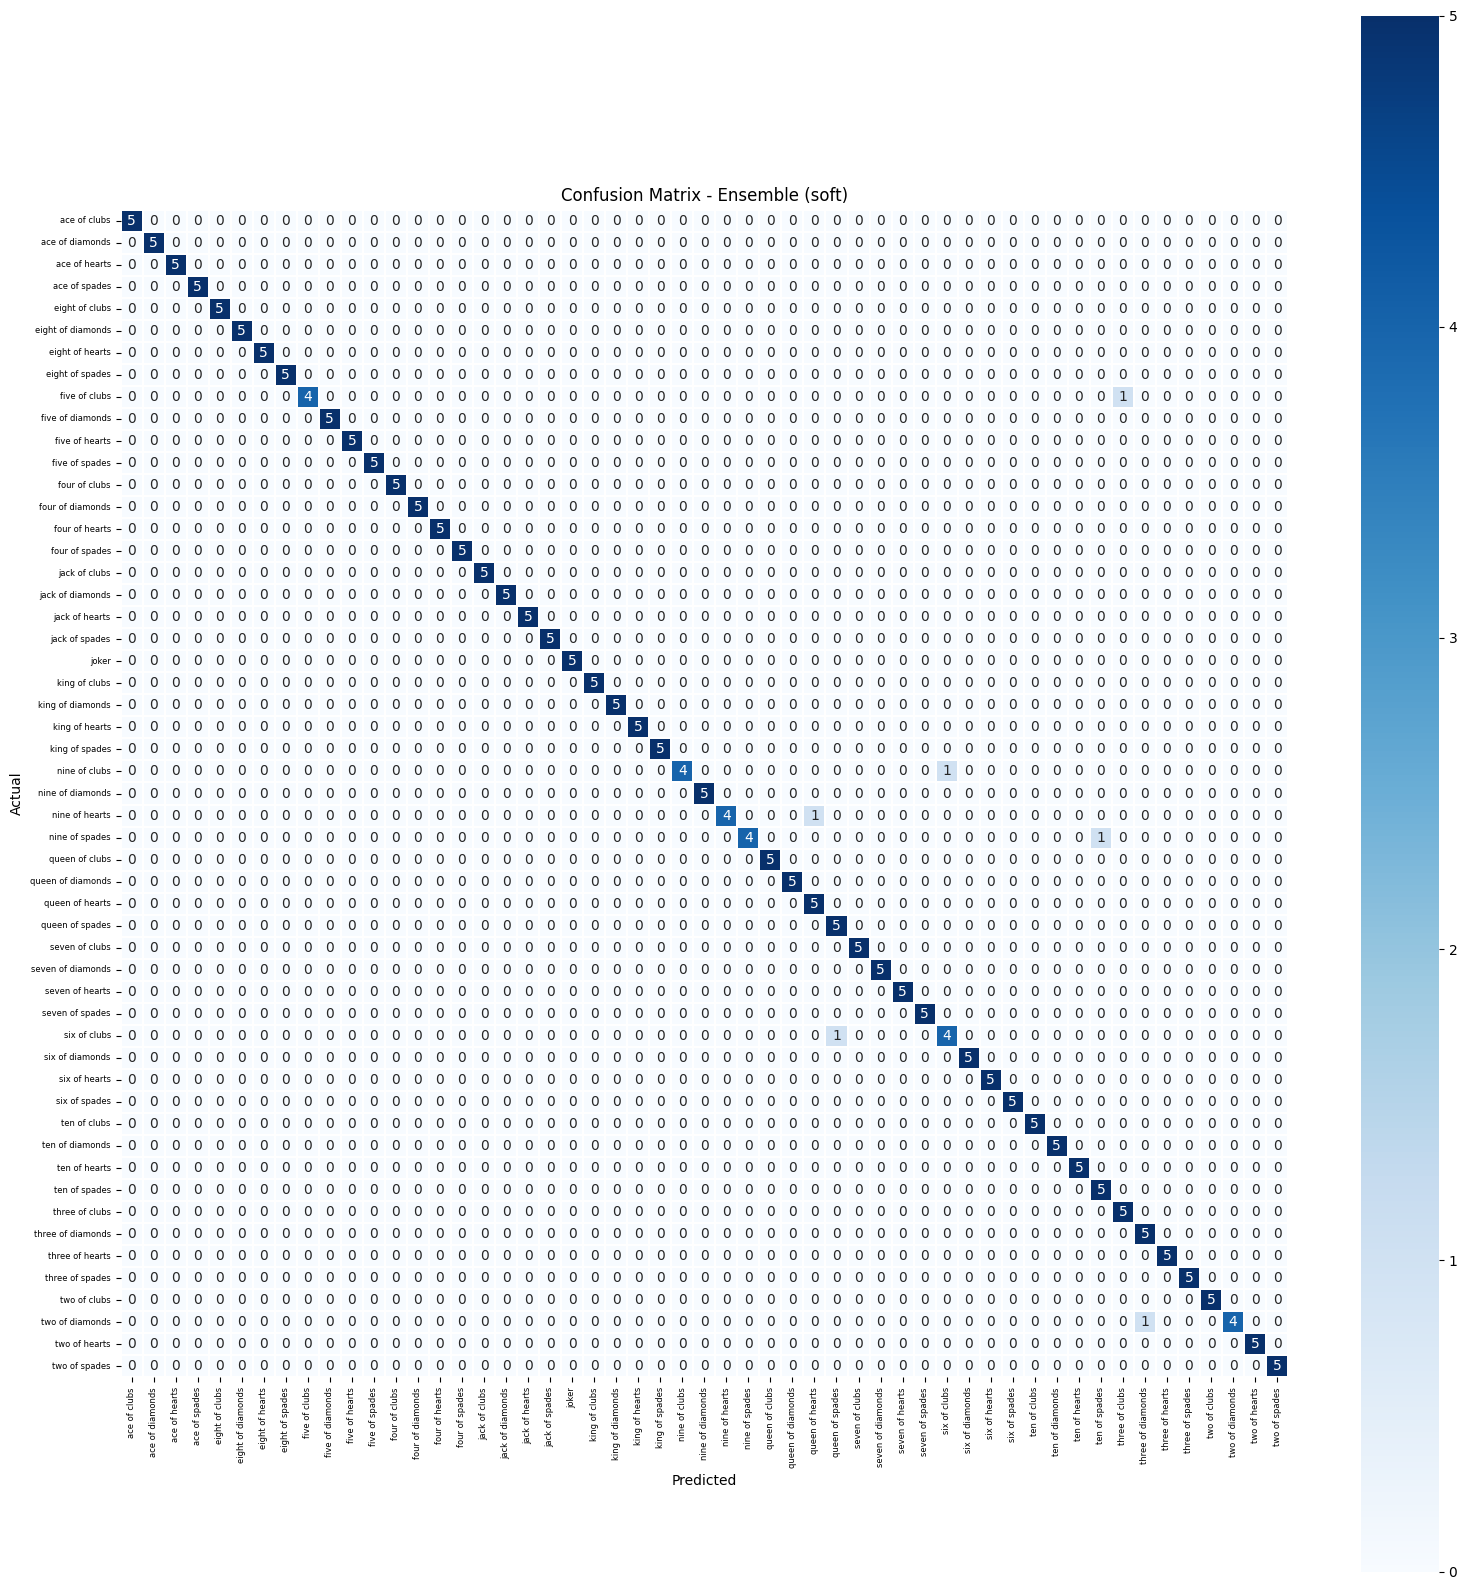

In [31]:
# Confusion Matrix
cf = confusion_matrix(true_labels, pred_classes)

fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(cf, annot=True, square=True, cbar=True,
            cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names, ax=ax, fmt='', linewidths=0.1)

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title(f'Confusion Matrix - Ensemble ({best_ensemble_type})')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig(os.path.join(path_results, 'ensemble_confusion_matrix.png'), dpi=150)
plt.show()

## Analisis de errores: Donde falla el ensemble?

In [32]:
# Identificar clases mas confundidas
errors = []
for i, (true, pred) in enumerate(zip(true_labels, pred_classes)):
    if true != pred:
        errors.append({
            'index': i,
            'true_class': class_names[true],
            'pred_class': class_names[pred],
            'confidence': best_ensemble_preds[i, pred]
        })

errors_df = pd.DataFrame(errors)
print(f'Total errores: {len(errors_df)} de {len(true_labels)} ({100*len(errors_df)/len(true_labels):.2f}%)')

Total errores: 6 de 265 (2.26%)


In [33]:
# Top 10 confusiones mas comunes
if len(errors_df) > 0:
    confusion_pairs = errors_df.groupby(['true_class', 'pred_class']).size().reset_index(name='count')
    confusion_pairs = confusion_pairs.sort_values('count', ascending=False).head(10)
    
    print('\nTop 10 confusiones mas comunes:')
    for _, row in confusion_pairs.iterrows():
        print(f"  {row['true_class']} -> {row['pred_class']}: {row['count']} veces")


Top 10 confusiones mas comunes:
  five of clubs -> three of clubs: 1 veces
  nine of clubs -> six of clubs: 1 veces
  nine of hearts -> queen of hearts: 1 veces
  nine of spades -> ten of spades: 1 veces
  six of clubs -> queen of spades: 1 veces
  two of diamonds -> three of diamonds: 1 veces


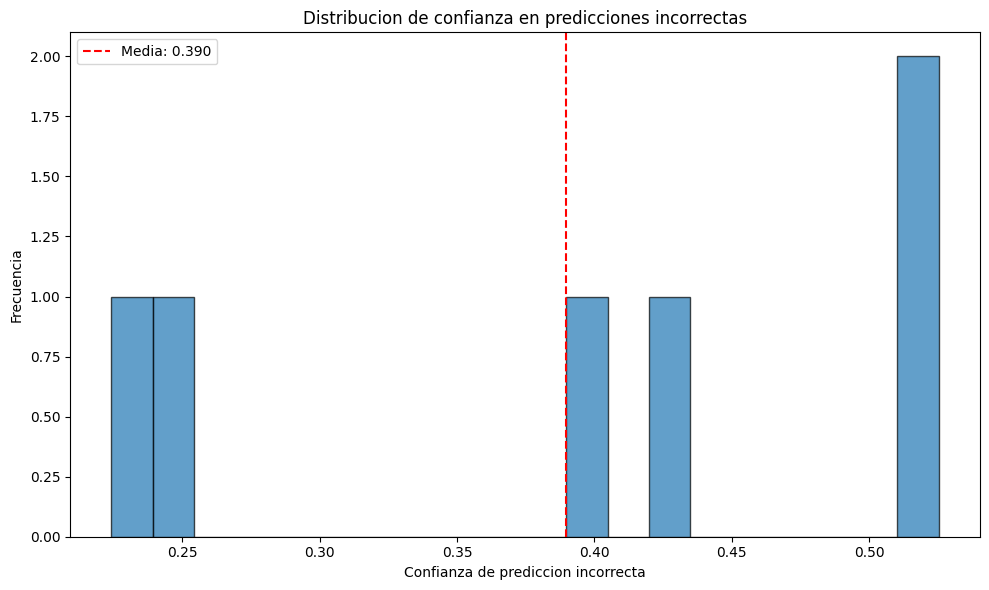

In [34]:
# Analisis de confianza en errores
if len(errors_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(errors_df['confidence'], bins=20, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Confianza de prediccion incorrecta')
    ax.set_ylabel('Frecuencia')
    ax.set_title('Distribucion de confianza en predicciones incorrectas')
    ax.axvline(errors_df['confidence'].mean(), color='red', linestyle='--', 
               label=f'Media: {errors_df["confidence"].mean():.3f}')
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(path_results, 'error_confidence_distribution.png'), dpi=150)
    plt.show()

## Guardar funcion de ensemble para inferencia

In [35]:
# Guardar configuracion del ensemble
ensemble_config = {
    'models': list(models.keys()),
    'model_files': [f'{name}.h5' for name in model_names],
    'individual_accuracies': individual_accuracies,
    'weights': optimized_weights if acc_optimized == max(ensemble_results.values()) else individual_accuracies,
    'ensemble_type': best_ensemble_type,
    'ensemble_accuracy': ensemble_results[best_ensemble_type]
}

import json
with open(os.path.join(path_models, 'ensemble_config.json'), 'w') as f:
    json.dump(ensemble_config, f, indent=2)

print('Configuracion del ensemble guardada en Models/ensemble_config.json')
print(json.dumps(ensemble_config, indent=2))

Configuracion del ensemble guardada en Models/ensemble_config.json
{
  "models": [
    "ViT",
    "MobileNet",
    "Custom"
  ],
  "model_files": [
    "ViT_B16_3.h5",
    "MobileNet_3.h5",
    "Custom_4.h5"
  ],
  "individual_accuracies": {
    "ViT": 0.9698113203048706,
    "MobileNet": 0.9283018708229065,
    "Custom": 0.9698113203048706
  },
  "weights": {
    "ViT": 0.9698113203048706,
    "MobileNet": 0.9283018708229065,
    "Custom": 0.9698113203048706
  },
  "ensemble_type": "soft",
  "ensemble_accuracy": 0.9773584905660377
}


In [36]:
# Resumen final
print('\n' + '='*60)
print('RESUMEN FINAL')
print('='*60)

best_individual = max(individual_accuracies.items(), key=lambda x: x[1])
best_ensemble = max(ensemble_results.items(), key=lambda x: x[1])

print(f'\nMejor modelo individual: {best_individual[0]} ({best_individual[1]:.4f})')
print(f'Mejor ensemble: {best_ensemble[0]} ({best_ensemble[1]:.4f})')

improvement = (best_ensemble[1] - best_individual[1]) * 100
if improvement > 0:
    print(f'\nMejora del ensemble sobre mejor individual: +{improvement:.2f}%')
else:
    print(f'\nEl mejor modelo individual supera al ensemble por: {-improvement:.2f}%')

print('='*60)


RESUMEN FINAL

Mejor modelo individual: ViT (0.9698)
Mejor ensemble: soft (0.9774)

Mejora del ensemble sobre mejor individual: +0.75%
